In [1]:
%load_ext autoreload
%autoreload 2
from context import rmlib
import rmlib.rmtools as rm
import random

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
config = {
    'active_components' : {
        'camera' : ['my_camera'],
        'hand' : ['my_hand'],
        'arm' : ['my_arm'],
        'cart' : [],
    },
    'my_components' : {
        'my_hand' : {
            "module_name" : "hands.vgc10",
            "class_name" : "VGC10",
            "finger_length": 0.0415,
            "finger_width_outer" : 0.015,
            "finger_width_inner" : 0.0,
            "finger_depth" : 0.014
        },
        'my_arm' : {
            "module_name" : "arms.ur5",
            "class_name" : "UR5",
            "ip_address" : "10.1.12.81",
            "xmlrpc_port" : "8003",
            "max_linear_speed" : 0.25,
            "max_linear_accel" : 1.2,
            "max_joint_speed" : 1.5,
            "max_joint_accel" : 1.4,
            "default_linear_speed" : 0.1,
            "default_joint_speed" : 0.7,
            "default_linear_accel" : 0.8,
            "default_joint_accel" : 0.8,
            
        },
        'my_camera' : {
            'module_name' : 'cameras.realsense',
            'class_name' : 'RealSense',
            'camera_model' : 'd415',
            'ci_cam_offset' : [-0.0179, -0.0753, -0.02],
            'pc_cam_offset' : [-0.0179, -0.0753, -0.02],
        },        
    },
}
robot = rmlib.robot.Robot(config)

Setting up robot please wait...
Robot Ready!


In [ ]:
robot.arm.power_on()

In [ ]:
robot.arm.brake_release()

In [51]:
%%time
robot.arm.get_tcp_pose()

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 20.4 ms


array([[-2.25021803e-03, -9.99997457e-01, -1.50504665e-04,
         4.86795297e-01],
       [-9.99981171e-01,  2.24932209e-03,  5.70940218e-03,
        -1.09610584e-01],
       [-5.70904913e-03,  1.63349231e-04, -9.99983690e-01,
         3.20711905e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [60]:
%%time
robot.get_capture()

CPU times: user 2.09 s, sys: 12 ms, total: 2.1 s
Wall time: 1.01 s


In [63]:
%%time
robot.camera.get_all()

UsageError: Line magic function `%%time` not found.


In [ ]:
robot.arm.move_to_common_pose('cv_2')

In [ ]:
robot.arm.move_to_common_pose('cv_1')

In [ ]:
robot.get_and_view_color()

In [ ]:
robot.camera.set_disparity_shift(0)
robot.get_and_view_depth()

In [ ]:
robot.get_and_view_cloud()

In [45]:
%%time
a = robot.get_capture()

CPU times: user 2.05 s, sys: 36 ms, total: 2.08 s
Wall time: 1.01 s


In [43]:
%%time
a = robot.camera.get_all()

CPU times: user 1.21 s, sys: 12 ms, total: 1.22 s
Wall time: 594 ms


# Cloud Segment

In [ ]:
robot.arm.move_to_common_pose('+y', speed_per=1)
model = robot.get_capture()
cloud = model.cloud

# cloud = rm.clouds.remove_planar_surface(cloud, rmv_tolerance=0.005)
cloud = rm.clouds.remove_far_points(cloud, 0.3)

cloud = rm.clouds.downsample(cloud, leaf_size=0.006, output=[])
clouds = rm.clouds.segment_dbscan(cloud, search_radius=0.007, min_samples=4, output=['all'])
clouds = rm.clouds.filter_by_size(clouds, dim_1=[0.2, 0.5], dim_2=[0.05, 0.2], dim_3=[0, 0])
clouds = rm.clouds.sort_by_size(clouds, large_to_small=False)
poses = rm.clouds.get_cloud_poses(clouds, frame='camera')



scene = rm.viewer.Scene_3D()
scene.add_cloud(clouds[0])
scene.add_axis(poses[0])
# scene.add_clouds(clouds)
# scene.add_axes(poses)
scene.render()

In [ ]:
pose = poses[0]

grasp_pose = (robot.camera_pose()).dot(pose)

grasp_pose = rm.poses.translate_pose(grasp_pose,[0,0,0.01])

grasp_pose = robot.limit_rotation_from_tcp(grasp_pose, frame='base')

robot.pick_part([grasp_pose,None], 0.2)

# Move back to home
robot.arm.move_to_common_pose('cv_2', speed_per=1)

# Move back to home
robot.arm.move_to_common_pose('cv_1', speed_per=1)

# Generate random place point
place_pose = rm.poses.translate_pose(robot.arm.get_tcp_pose(),[0,0,0.177])
# place_pose = rm.poses.translate_pose(robot.arm.get_tcp_pose(),[random.uniform(-0.15,0.15),random.uniform(-0.05,0.05),0.177])
# rz = random.uniform(-1.5, 1.5)
# print(rz)
# place_pose = rm.poses.rotate_pose(place_pose, [0,0,rz])

robot.place_part(place_pose, 0.1)

# Detectron Segment

In [30]:
from detectron2.engine import DefaultPredictor

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

class Predictor(DefaultPredictor):
    def __init__(self, config_path, weights_path, threshold):
        cfg = get_cfg()
        cfg.merge_from_file(config_path)

        cfg.MODEL.WEIGHTS = weights_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
        
        super().__init__(cfg)       
    
    @staticmethod
    def make_composite_image_with_mask(
            background_image: np.ndarray,
            foreground_image: np.ndarray,
            foreground_mask: np.ndarray) -> (np.ndarray, np.ndarray):
        """
        Copies pixels from foreground_image to background_image where foreground_mask values are greater tha 0
        """

        background_image[np.where(foreground_mask > 0)] = foreground_image[np.where(foreground_mask > 0)]
       
        return background_image
    
    def depth_segmentation(self, rgb_image, depth_image):
        """
            
        """
        if not rgb_image.shape[:1] == depth_image.shape[:1]:
            # resize rgb to match size of depth
            size = (depth_image.shape[1], depth_image.shape[0])
            rgb_image = cv2.resize(rgb_image, dsize=size, interpolation=cv2.INTER_CUBIC)
            print(rgb_image.shape)  
        
        # get predictions
        predictions = self.__call__(rgb_image)
        
        # get masks
        pred_masks = predictions["instances"].pred_masks
        
        
        num_masks = len(pred_masks)
        
        depth_segmentation = np.zeros_like(depth_image)
        color_segmentation = np.zeros_like(rgb_image)
        
        print('Objects Found:', num_masks)
        if num_masks > 0:

            pred_masks_np = pred_masks[0].cpu().numpy()
             
            squeezed = pred_masks_np.squeeze()

            depth_segmentation = Predictor.make_composite_image_with_mask(depth_segmentation, depth_image, squeezed)
            color_segmentation = Predictor.make_composite_image_with_mask(color_segmentation, rgb_image, squeezed)
            
            fig, ax = plt.subplots(figsize=(20, 20))
            ax.set_yticks(np.arange(0, 720, 80))
            ax.set_xticks(np.arange(0, 1280, 80))
            ax.imshow(color_segmentation)
            plt.show()
            
            return depth_segmentation
        
        else:
            return None

In [31]:
%%time
base_dir = '/home/nvidia/detectron_models/'
model = 'ipw_box_2'
dir_path = base_dir + model +'/'

config_absolute_path = dir_path+'config.yaml'
assert os.path.exists(config_absolute_path) and os.path.isfile(config_absolute_path)

weights_absolute_path = dir_path+'model.pth'
assert os.path.exists(weights_absolute_path) and os.path.isfile(weights_absolute_path)

predictor = Predictor(config_path=config_absolute_path, weights_path=weights_absolute_path, threshold=0.5)

CPU times: user 8.88 s, sys: 348 ms, total: 9.22 s
Wall time: 4.48 s


(720, 1280, 3)
Objects Found: 3


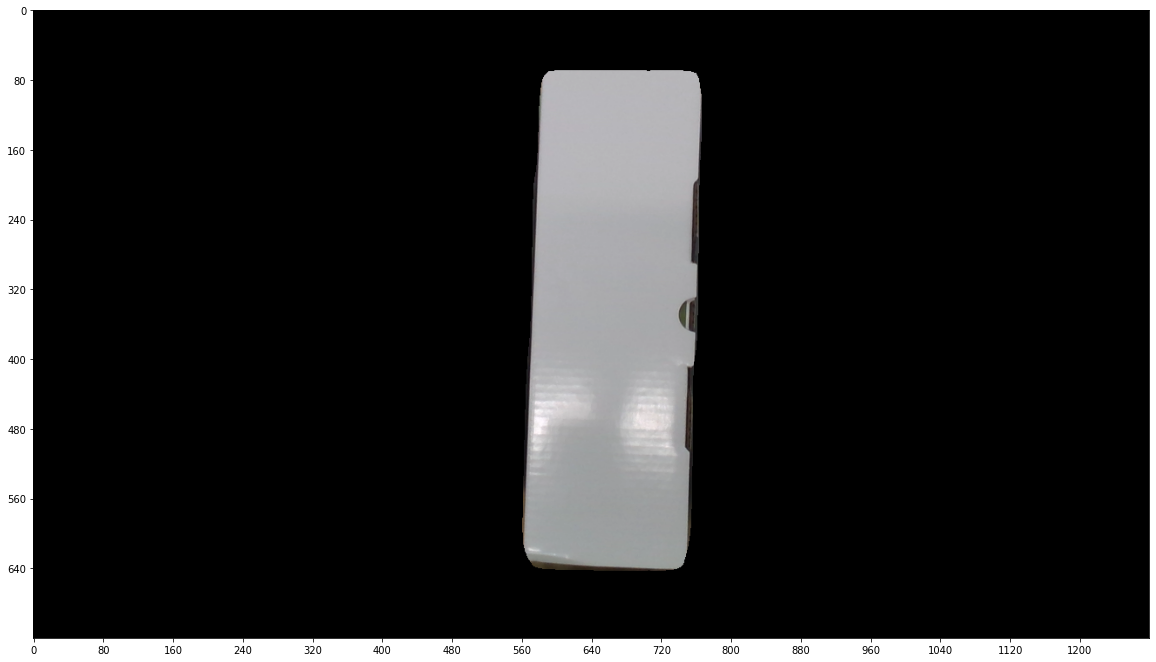

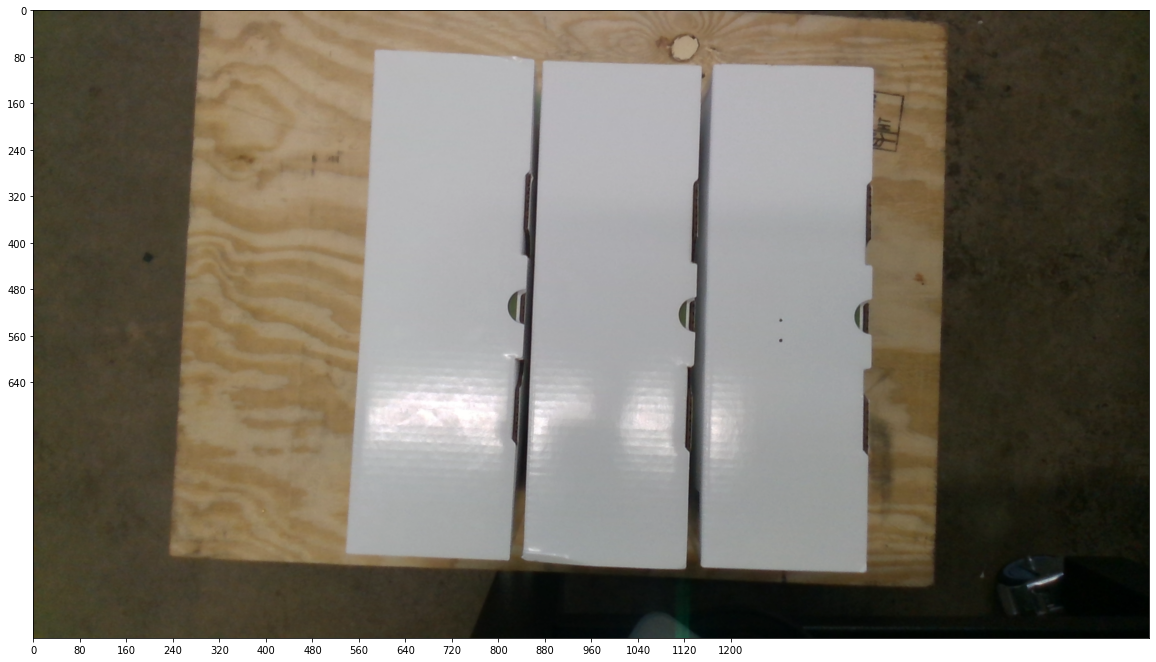

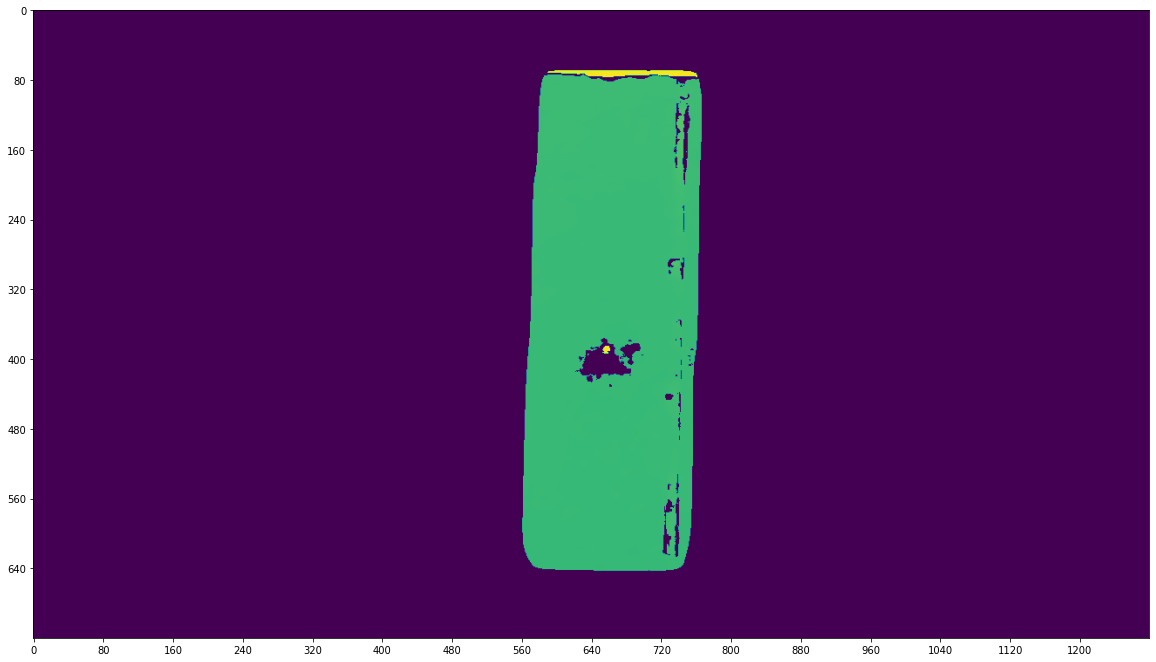

In [36]:
robot.arm.move_to_common_pose('+x', speed_per=1)

capture = robot.get_capture()



# Pre Process
# full_cloud = rm.clouds.remove_far_points(capture.cloud, 0.2)
# full_cloud = rm.clouds.downsample(full_cloud, leaf_size=0.008, output=[])

# Find Feature Poses
segmented_depth = predictor.depth_segmentation(rgb_image=capture.color_image, depth_image=capture.depth_image)

robot.get_and_view_color()
if segmented_depth is None:
    raise Exception('No objects found')
rm.viewer.show_image(segmented_depth)

In [39]:
## %%time
cloud = robot.camera.convert_depth_image_to_cloud(segmented_depth)

rm.viewer.show_cloud(cloud)

cloud = rm.clouds.downsample(cloud, leaf_size=0.006, output=[])

clouds = rm.clouds.segment_nbscan(cloud, curve_threshold=0.01, angle_threshold=0.015, k=10, output=['all'])
# clouds = rm.clouds.segment_dbscan(cloud, search_radius=0.0061, min_samples=4, output=['all'])

clouds = rm.clouds.filter_by_size(clouds, dim_1=[0.07, 0.17], dim_2=[0.21, 0.31], dim_3=[0.32, 0.42], output=['all'])

clouds = rm.clouds.sort_by_size(clouds, large_to_small=False, output=[])

poses = rm.clouds.get_cloud_poses(clouds, frame='camera')

# Find Feature Grasp

scene = rm.viewer.Scene_3D()
scene.add_cloud(clouds[0], colorize=True)
# scene.add_cloud(full_cloud)
scene.add_axis(poses[0])
# scene.add_clouds(clouds)
# scene.add_axes(poses)
scene.render()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.02355605491928764, 0.17351470734540203, 1.…

Segment Cloud NBScan Output:


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.013487786714655507, 0.010899172117092019, …

axis_1: 0.019481585687483028  axis_2: 0.10969871438877779  axis_3: 0.358029527399115


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.007316929460082027, 0.023662998472024688, …

In [ ]:
robot.arm.move_to_common_pose('+y', speed_per=1)
pose = poses[0]

grasp_pose = (robot.camera_pose()).dot(pose)

grasp_pose = rm.poses.translate_pose(grasp_pose,[0,0,0.03])

grasp_pose = robot.limit_rotation_from_tcp(grasp_pose, frame='base')

robot.pick_part(grasp_pose, 0.3, force_limit=20)


# Move back to home
robot.arm.move_to_common_pose('cv_2', speed_per=1)

# Move back to home
robot.arm.move_to_common_pose('cv_1', speed_per=1)

# Generate random place point
offset = 0
place_pose = rm.poses.translate_pose(robot.arm.get_tcp_pose(),[offset,0,0.177])
# place_pose = rm.poses.translate_pose(robot.arm.get_tcp_pose(),[random.uniform(-0.15,0.15),random.uniform(-0.05,0.05),0.177])
# rz = random.uniform(-1.5, 1.5)
# print(rz)
# place_pose = rm.poses.rotate_pose(place_pose, [0,0,rz])

robot.place_part(place_pose, 0.1)

# Loop

In [ ]:
robot.hand.release()
robot.arm.move_to_common_pose('cv_1', speed_per=1)
drop_pose_start = robot.arm.get_tcp_pose()

for i in range(3):
    robot.arm.move_to_common_pose('+x', speed_per=1)
    capture = robot.get_capture()

    segmented_depth = predictor.predict_depth_segmentation(rgb_image=capture.color_image, depth_image=capture.depth_image)

#     robot.get_and_view_color()
    if segmented_depth is None:
        raise Exception('No objects found')

#     rm.viewer.show_image(segmented_depth)

#     full_cloud = rm.clouds.downsample(capture.cloud, leaf_size=0.006, output=[])

    cloud = robot.camera.convert_depth_image_to_cloud(segmented_depth)
    cloud = rm.clouds.downsample(cloud, leaf_size=0.006, output=[])
    clouds = rm.clouds.segment_nbscan(cloud, curve_threshold=0.01, angle_threshold=0.015, k=10, output=[])
    clouds = rm.clouds.filter_by_size(clouds, dim_1=[0.07, 0.17], dim_2=[0.21, 0.31], dim_3=[0.32, 0.42])
    clouds = rm.clouds.sort_by_size(clouds, large_to_small=True)
    poses = rm.clouds.get_cloud_poses(clouds, frame='camera')

#     scene = rm.viewer.Scene_3D()
#     scene.add_cloud(clouds[0], colorize=True)
#     scene.add_cloud(full_cloud)
#     scene.add_axis(poses[0])
#     # scene.add_clouds(clouds)
#     # scene.add_axes(poses)
#     scene.render()

    robot.arm.move_to_common_pose('+x', speed_per=1)
    pose = poses[0]

    grasp_pose = (robot.camera_pose()).dot(pose)

    grasp_pose = rm.poses.translate_pose(grasp_pose,[0,0,0.03])

    grasp_pose = robot.limit_rotation_from_tcp(grasp_pose, frame='base')

    robot.pick_part(grasp_pose, 0.3, pick_speedl=0.1, force_limit=20)


#     # Move back to home
#     robot.arm.move_to_common_pose('cv_2', speed_per=1)

    # Move back to home
    robot.arm.move_to_common_pose('+x', speed_per=1)

    # Generate random place point
    offset = [0.15,0,-0.15]
    place_pose = rm.poses.translate_pose(drop_pose_start,[offset[i],0,0.177])
    # place_pose = rm.poses.translate_pose(robot.arm.get_tcp_pose(),[random.uniform(-0.15,0.15),random.uniform(-0.05,0.05),0.177])
    # rz = random.uniform(-1.5, 1.5)
    # print(rz)
    # place_pose = rm.poses.rotate_pose(place_pose, [0,0,rz])

    robot.place_part(place_pose, 0.1)

In [ ]:
setup = {
    'pre_process' : {
        'downsample' : {
            leafsize : 
        }
    'feature_process' : 
        
    }
}

In [ ]:
# Assume: cloud has been downsampled and containers removed
    
def find_feature(capture, feature):
    
    
    

In [ ]:
feature = {
    'shape' : 'box',
    'x_axis': [0.07, 0.085],
    'y_axis': [0.07, 0.085],
    'z_axis': [0, 0],    
}
leaf_size = 0.006
crop_dist = 2

capture = robot.get_capture()
capture.cloud = rm.clouds.downsample(capture.cloud, leaf_size=leaf_size, output=[])
capture.leaf_size = leaf_size
capture.cloud = rm.clouds.remove_far_points(capture.cloud, crop_dist)

find_feature(capture, feature)



In [ ]:
robot.arm.move_to_common_pose('cv_1')

In [ ]:
robot.arm.move_to_common_pose('cv_1')
drop_pose_start = robot.arm.get_tcp_pose()

In [ ]:
robot.hand.release()

In [ ]:
print(robot.arm.get_joint_angles())

In [ ]:
cloud = robot.camera.get_cloud()
rm.clouds.save(cloud, './test_data/cloud')

In [ ]:
img = robot.camera.get_color_image()
rm.images.save(img,'./test_data/color_image')

In [ ]:
img = robot.camera.get_depth_image()
rm.images.save(img,'./test_data/depth_image')

In [ ]:
robot.arm.power_off()